In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
%matplotlib inline

In [15]:
start_date = pd.to_datetime('2014-01-01')
end_date = pd.to_datetime('2019-12-31')

# Assuming portfolio consists of 4 stocks = Apple, Nike, Amazon, McDonald's
aapl = web.DataReader('AAPL', 'yahoo', start=start_date, end=end_date)
nike = web.DataReader('NKE', 'yahoo', start=start_date, end=end_date)
amzn = web.DataReader('AMZN', 'yahoo', start=start_date, end=end_date)
mcd = web.DataReader('MCD', 'yahoo', start=start_date, end=end_date)

In [31]:
stocks = pd.concat([aapl['Close'], nike['Close'], amzn['Close'], mcd['Close']], axis=1)
stocks.columns = ['AAPL', 'NIKE', 'AMAZON', 'MCD']

<AxesSubplot:xlabel='Date'>

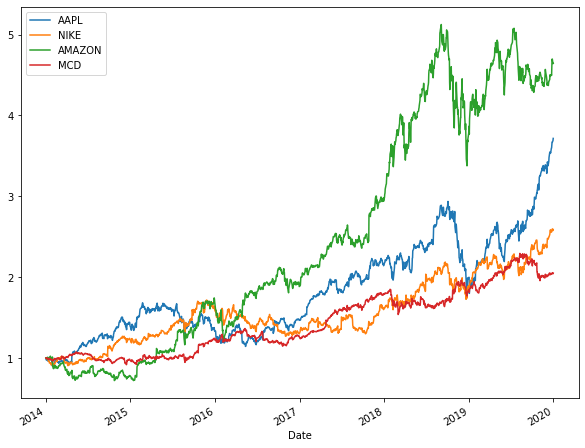

In [34]:
# Visualizing the cumulative returns of each individual stock
cumulative_returns = stocks/stocks.iloc[0]
cumulative_returns.plot(figsize=(10,8))

In [36]:
# Calculating the log returns
log_ret = np.log(stocks / stocks.shift(1))

In [49]:
log_ret

,AAPL,NIKE,AMAZON,MCD
Date,,,,
2014-01-02,NaN,NaN,NaN,NaN
2014-01-03,-0.022211,-0.002688,-0.003852,0.001347
2014-01-06,0.005438,-0.007719,-0.007113,-0.007173
2014-01-07,-0.007177,0.000775,0.011116,0.005514
2014-01-08,0.006313,-0.005175,0.009726,-0.010115
...,...,...,...,...
2019-12-24,0.000950,0.000999,-0.002116,0.002393
2019-12-26,0.019646,0.005676,0.043506,0.001981
2019-12-27,-0.000380,0.008503,0.000551,0.005617


## Monte Carlo Simulations

In [66]:
def get_ret_vol_sr(weights, log_return_mean, log_return_cov):
    """
        Takes in portfolio allocations, and returns the portfolio return, volatility and Sharpe Ratio
    """
    weights = np.array(weights)
    
    # the expected portfoio return
    port_ret = np.sum(log_return_mean * weights)
    
    # the expected portfolio variance/volatility
    port_vol = np.sqrt(np.dot(weights.T, np.dot(log_return_cov, weights)))
    
    # the sharpe ratio
    # assuming the risk free return in the sharpe ratio formula to be 0
    port_sr = port_ret / port_vol
    
    return [port_ret, port_vol, port_sr]

In [74]:
num_portfolios = 10000

all_weights = np.zeros((num_portfolios, len(stocks.columns)))
ret_arr = np.zeros(num_portfolios)
vol_arr = np.zeros(num_portfolios)
sr_arr = np.zeros(num_portfolios)

# the annualized log return mean
log_return_mean = log_ret.mean() * 252

# annualized log return covariance matrix
log_return_cov = log_ret.cov() * 252

for i in range(num_portfolios):
    # get the weights
    weights = np.random.random(4)
    
    # rebalance the weights so that the sum is 1
    weights /= np.sum(weights)
    
    # store the weights
    all_weights[i,:] = weights;
    
    # calculate the portfolio return, volatility, and sharpe ratio
    res = get_ret_vol_sr(weights, log_return_mean, log_return_cov)
    
    # store the portfolio return
    ret_arr[i] = res[0]
    
    # store the portfolio volatility
    vol_arr[i] = res[1]
    
    # store the sharpe ratio
    sr_arr[i] = res[2]